This notebooks has for objective to identify optimal LFR_benchmark parameters to generate networks with similar graph properties as E Coli.

In [1]:
# Editing mode
%load_ext autoreload
%autoreload 2

In [11]:
import pandas as pd
import networkx as nx
import matplotlib as plt
import networkx as nx
import random
from scipy.stats import pearsonr
import GRNgene as gg
import cma
import numpy as np
from scipy.stats import ks_2samp
random.seed(1)

# E.Coli network property

In [3]:
filepath = '../../data/gnw/Ecoli-full.tsv'
adj_mx = gg.adj_mx_gnw_goldstandard(filepath)
ecoli_grn = nx.from_numpy_array(adj_mx, create_using=nx.DiGraph())

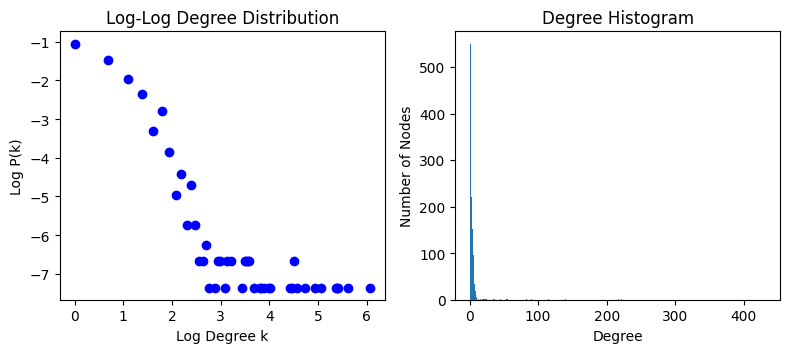

In [4]:
gg.plot_grn_degree(ecoli_grn, plot_network=False)
gnw_properties = gg.network_properties(ecoli_grn)

In [5]:
# Get in- and out-degree distributions
deg_in_ecoli = np.array([d for _, d in ecoli_grn.in_degree()])
deg_out_ecoli = np.array([d for _, d in ecoli_grn.out_degree()])

In [6]:
deg_ecoli = np.array([d for _, d in ecoli_grn.degree()])

In [11]:
deg_ecoli.shape

(1564,)

In [7]:
gnw_properties

{'avg_clustering': 0.13291362343159122,
 'avg_degree': 4.664961636828645,
 'degrees': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  18,  19,  20,  22,  23,  25,  31,  33,  34,  35,
         36,  40,  45,  46,  49,  54,  55,  83,  87,  90,  97, 115, 140,
        158, 217, 218, 222, 278, 431]),
 'density': 0.0014923101845261179,
 'degree_proba': array([0.35102302, 0.22826087, 0.14130435, 0.09654731, 0.03644501,
        0.06138107, 0.02109974, 0.00703325, 0.01214834, 0.00319693,
        0.00895141, 0.00319693, 0.00127877, 0.00127877, 0.00191816,
        0.00063939, 0.00063939, 0.00127877, 0.00127877, 0.00063939,
        0.00127877, 0.00127877, 0.00063939, 0.00127877, 0.00127877,
        0.00127877, 0.00127877, 0.00063939, 0.00063939, 0.00063939,
        0.00063939, 0.00063939, 0.00063939, 0.00063939, 0.00063939,
        0.00127877, 0.00063939, 0.00063939, 0.00063939, 0.00063939,
        0.00063939, 0.00063939, 0.00063939, 0.00063939, 0.000

In [8]:
import networkx as nx

# Get the largest weakly connected component
largest_weakly_cc = max(nx.weakly_connected_components(ecoli_grn), key=len)

# Create the subgraph
ecoli_largest = ecoli_grn.subgraph(largest_weakly_cc).copy()


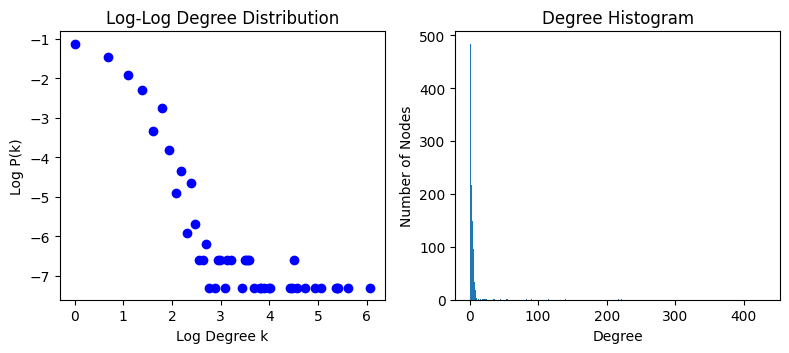

In [ ]:
gg.plot_grn_degree(ecoli_largest, plot_network=False)
gnw_properties = gg.network_properties(ecoli_largest)

In [31]:
gnw_properties

{'avg_clustering': 0.1393885626587736,
 'avg_degree': 4.844955991875423,
 'degrees': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  18,  19,  20,  22,  23,  25,  31,  33,  34,  35,
         36,  40,  45,  46,  49,  54,  55,  83,  87,  90,  97, 115, 140,
        158, 217, 218, 222, 278, 431]),
 'density': 0.0016412452547003467,
 'degree_proba': array([0.32701422, 0.23561273, 0.14691943, 0.10088016, 0.03588355,
        0.06431957, 0.02234259, 0.00744753, 0.01286391, 0.00270819,
        0.00947867, 0.00338524, 0.0013541 , 0.0013541 , 0.00203114,
        0.00067705, 0.00067705, 0.0013541 , 0.0013541 , 0.00067705,
        0.0013541 , 0.0013541 , 0.00067705, 0.0013541 , 0.0013541 ,
        0.0013541 , 0.0013541 , 0.00067705, 0.00067705, 0.00067705,
        0.00067705, 0.00067705, 0.00067705, 0.00067705, 0.00067705,
        0.0013541 , 0.00067705, 0.00067705, 0.00067705, 0.00067705,
        0.00067705, 0.00067705, 0.00067705, 0.00067705, 0.0006

# Metric definition

In [22]:
def total_score(network1, network2):
    degree_dist_1 = np.array([d for _, d in network1.degree()])
    degree_dist_2 = np.array([d for _, d in network2.degree()])
    degree_dist_ks = ks_2samp(degree_dist_1, degree_dist_2)

    in_degree_dist_1 = np.array([d for _, d in network1.in_degree()])
    in_degree_dist_2 = np.array([d for _, d in network2.in_degree()])
    in_degree_dist_ks = ks_2samp(in_degree_dist_1, in_degree_dist_2)

    out_degree_dist_1 = np.array([d for _, d in network1.out_degree()])
    out_degree_dist_2 = np.array([d for _, d in network2.out_degree()])
    out_degree_dist_ks = ks_2samp(out_degree_dist_1, out_degree_dist_2)

    edge_1 = network1.number_of_edges()
    edge_2 = network2.number_of_edges()
    edge_diff = (edge_1 - edge_2)**2

    avg_clustering_1 = nx.average_clustering(network1)
    avg_clustering_2 = nx.average_clustering(network2)
    avg_clustering_diff = (avg_clustering_1 - avg_clustering_2)**2

    return (
    degree_dist_ks.statistic +
    in_degree_dist_ks.statistic +
    out_degree_dist_ks.statistic +
    edge_diff +
    avg_clustering_diff
    )

In [ ]:
# def weighted_total_score(true_network, synthetic_network):
#     degree_dist_true = np.array([d for _, d in true_network.degree()])
#     degree_dist_synth = np.array([d for _, d in synthetic_network.degree()])
#     ks_total = ks_2samp(degree_dist_true, degree_dist_synth)

#     in_degree_dist_true = np.array([d for _, d in true_network.in_degree()])
#     in_degree_dist_synth = np.array([d for _, d in synthetic_network.in_degree()])
#     ks_in = ks_2samp(in_degree_dist_true, in_degree_dist_synth)

#     out_degree_dist_true = np.array([d for _, d in true_network.out_degree()])
#     out_degree_dist_synth = np.array([d for _, d in synthetic_network.out_degree()])
#     ks_out = ks_2samp(out_degree_dist_true, out_degree_dist_synth)

#     edge_true = true_network.number_of_edges()
#     edge_synth = synthetic_network.number_of_edges()
#     edge_diff = (edge_true - edge_synth)/edge_true

#     avg_clustering_1 = nx.average_clustering(true_network)
#     avg_clustering_2 = nx.average_clustering(synthetic_network)
#     avg_clustering_diff = (avg_clustering_1 - avg_clustering_2)**2

#     # Weights
#     w_ks_total = 0.25
#     w_ks_in = 0.2
#     w_ks_out = 0.2
#     w_edge = 0.25
#     w_cluster = 0.1

#     return (
#         w_ks_total * ks_total +
#         w_ks_in * ks_in +
#         w_ks_out * ks_out +
#         w_edge * edge_diff +
#         w_cluster * avg_clustering_diff
#     )

In [ ]:
def evaluate_lfr(true_network, params):
    tau1, tau2, mu, hub_bias, min_community, max_community = params

    try:
        LFR_params = dict(
        n=true_network.number_of_nodes(),
        tau1=tau1,
        tau2=tau2,
        mu=mu,

        average_degree=4.8,
        min_community=min_community,
        max_community=max_community,
        hub_bias = hub_bias,
        seed=None
        )
        
        G_lfr = gg.LFRAlgorithm(max_retries=20,**LFR_params)

        G_lfr_directed = gg.adjacenteDiMatriceStaredFromGraph(
            G_lfr,
            autoRG=0.0,   # self-loop probability
            duoRG=0.005    # bidirectional edge probability
        )
        print(f"Computing score...")
        # Compare distributions
        score = total_score(true_network, G_lfr_directed[0])
        print(f"Score: {score}")
        return score

    except Exception:
        return np.inf  # penalize failures


# Optimization

In [25]:
import cma

# CMA-ES initial guess (tau1, tau2, mu, hub_bias, min_community, max_community)
x0 = [2.3, 1.2, 0.5, 3, 5, 500]
sigma0 = 0.3  # Initial standard deviation

es = cma.CMAEvolutionStrategy(x0, sigma0, {'bounds': [[1.5, 1.1, 0.05, 1, 2, 100], [5.0, 3.0, 0.85, 5, 50, 1000]]})

history = []

while not es.stop():
    solutions = es.ask()
    fitnesses = [evaluate_lfr(ecoli_largest, sol) for sol in solutions]
    for s, f in zip(solutions, fitnesses):
        history.append({'params': s, 'score': f})
    es.tell(solutions, fitnesses)
    es.logger.add()
    es.disp()
    # Save progress
    if es.countiter % 5 == 0:
        es.save("cma_checkpoint.pkl")
        pd.DataFrame(history).to_csv("cma_history.csv", index=False)

c:\Users\aetl_sur\AppData\Local\anaconda3\envs\venv_grnsim\lib\site-packages\cma\evolution_strategy.py:1244: UserWarning: Sampling standard deviation i=2 at iteration 0 change by 0.88887407419753 to stds[2]=0.2666666666666666
  warnings.warn("Sampling standard deviation i={0} at iteration {1}"


(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=1001284, Thu May 22 16:44:51 2025)
Generation failed on attempt 1, retrying...
Generation failed on attempt 2, retrying...
Generation failed on attempt 3, retrying...
Generation failed on attempt 4, retrying...
Generation failed on attempt 5, retrying...
Generation failed on attempt 6, retrying...
Generation failed on attempt 7, retrying...
Generation failed on attempt 8, retrying...
Generation failed on attempt 9, retrying...
Generation failed on attempt 10, retrying...
Generation failed on attempt 11, retrying...
Generation failed on attempt 12, retrying...
Generation failed on attempt 13, retrying...
Generation failed on attempt 14, retrying...
Generation failed on attempt 15, retrying...
Generation failed on attempt 16, retrying...
Generation failed on attempt 17, retrying...
Generation failed on attempt 18, retrying...
Generation failed on attempt 19, retrying...
Generation failed on attempt 20, retrying...
Graph is disconnec

c:\Users\aetl_sur\AppData\Local\anaconda3\envs\venv_grnsim\lib\site-packages\cma\utilities\utils.py:347: UserWarning: function values with index [0, 7, 8] are not finite but [inf, inf, inf]. (time=May 22 16:47:36 2025 class=CMAEvolutionStrategy method=ask)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


Graph is disconnected. Connecting components...
Connected node 1228 (deg=185) with 23 (deg=2)
Connected node 1228 (deg=186) with 60 (deg=2)
Connected node 1129 (deg=51) with 1473 (deg=2)
Connected node 230 (deg=97) with 1273 (deg=2)
Connected node 1228 (deg=187) with 155 (deg=1)
Connected node 1228 (deg=188) with 432 (deg=2)
Connected node 1228 (deg=189) with 1206 (deg=2)
Connected node 1129 (deg=52) with 716 (deg=1)
Connected node 1228 (deg=190) with 977 (deg=2)
Connected node 1228 (deg=191) with 994 (deg=2)
Connected node 1228 (deg=192) with 1047 (deg=1)
Graph is now connected (added 11 edges).
Successfully generated LFR graph on attempt 1.
Computing score...
Degrees loaded.
Score: 564001.8008057537
Successfully generated LFR graph on attempt 1.
Computing score...
Degrees loaded.
Score: 547601.3051948303
Graph is disconnected. Connecting components...
Connected node 925 (deg=600) with 1024 (deg=2)
Connected node 925 (deg=601) with 54 (deg=2)
Connected node 925 (deg=602) with 62 (deg=

KeyboardInterrupt: 

# Load results

In [ ]:
# Load results
es = cma.CMAEvolutionStrategy.load("cma_checkpoint.pkl")
best_params = es.result.xbest
print("Best parameters:", best_params)

In [ ]:
best_params = es.result.xbest
print("Best parameters:", best_params)

#Best parameters: [2.33349812 1.11019687 0.67158893 2.48584554 3.711577  ]

Best parameters: [  2.11905595   1.20991633   0.50243064   3.14983374   5.10054852
 500.4941408 ]


In [29]:
tau1, tau2, mu, hub_bias, min_community, max_community = best_params

LFR_params = dict(
n=ecoli_largest.number_of_nodes(),
tau1=tau1,
tau2=tau2,
mu=mu,
seed=None,
average_degree=4.8,
min_community=min_community,
max_community=max_community,
hub_bias = hub_bias
)

G_lfr = gg.LFRAlgorithm(max_retries=20,**LFR_params)

G_lfr_directed = gg.adjacenteDiMatriceStaredFromGraph(
    G_lfr,
    autoRG=0.0,   # self-loop probability
    duoRG=0.005    # bidirectional edge probability
)

gg.network_properties(G_lfr_directed[0])

Successfully generated LFR graph on attempt 1.


{'avg_clustering': 0.1214329576012759,
 'avg_degree': 7.113067027758971,
 'degrees': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  24,  25,  27,  28,
         29,  31,  32,  33,  36,  38,  39,  40,  50,  51,  55,  59,  60,
         62,  72,  88,  94, 101, 110, 152, 158, 176, 223, 305, 577, 715]),
 'density': 0.0024095755514088654,
 'degree_proba': array([0.02911307, 0.09817197, 0.18551117, 0.24306026, 0.17535545,
        0.08666215, 0.05822613, 0.0338524 , 0.0169262 , 0.01083277,
        0.00880162, 0.00270819, 0.00677048, 0.00744753, 0.00338524,
        0.0013541 , 0.00203114, 0.0013541 , 0.00203114, 0.00203114,
        0.0013541 , 0.00067705, 0.00067705, 0.00067705, 0.0013541 ,
        0.00067705, 0.00067705, 0.00067705, 0.00067705, 0.00067705,
        0.0013541 , 0.00067705, 0.00067705, 0.00067705, 0.00067705,
        0.00067705, 0.00067705, 0.00067705, 0.00067705, 0.0013541 ,
        0.00067705, 0.00067

# Check solution

In [30]:
tau1, tau2, mu, hub_bias, average_degree = best_params

In [32]:
LFR_params = dict(
    n=ecoli_largest.number_of_nodes(),
    tau1=tau1,
    tau2=tau2,
    mu=mu,
    average_degree=average_degree,
    # min_community=10,
    # max_community=300,
    seed=None # Set seed for reproducibility
) # 2600 noeuds


hub_bias = hub_bias

# Generate LFR graph with retry loop to 1 since we set the seed
G_lfr = gg.LFRAlgorithm(max_retries=1,**LFR_params)

# Apply direction assignment
G_lfr_directed = gg.adjacenteDiMatriceStaredFromGraph(
    G_lfr,
    autoRG=0.0,   # self-loop probability
    duoRG=0.005    # bidirectional edge probability
)
#nx.write_adjlist(G_lfr_directed, "g_lfr_directed_final_2600.adjlist") # random

Graph is disconnected. Connecting components...
Connected node 1348 (deg=288) with 77 (deg=2)
Connected node 1348 (deg=289) with 1321 (deg=3)
Connected node 1081 (deg=237) with 993 (deg=2)
Connected node 153 (deg=64) with 231 (deg=2)
Connected node 469 (deg=127) with 271 (deg=2)
Connected node 1348 (deg=290) with 272 (deg=2)
Connected node 1348 (deg=291) with 830 (deg=2)
Connected node 48 (deg=64) with 1442 (deg=2)
Connected node 1081 (deg=238) with 1256 (deg=2)
Connected node 469 (deg=128) with 1360 (deg=2)
Connected node 1348 (deg=292) with 1469 (deg=1)
Graph is now connected (added 11 edges).
Successfully generated LFR graph on attempt 1.


In [33]:
synth_grn_properties = gg.network_properties(G_lfr_directed[0])

In [34]:
synth_grn_properties

{'avg_clustering': 0.02420369154122208,
 'avg_degree': 3.876777251184834,
 'degrees': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  21,  22,  23,  24,  26,  31,  41,  43,
         49,  64,  65,  95, 130, 239, 295]),
 'density': 0.001313271426553128,
 'degree_proba': array([0.18551117, 0.29451591, 0.21868653, 0.14556534, 0.05619499,
        0.03249831, 0.01421801, 0.01083277, 0.00541638, 0.00406229,
        0.00609343, 0.00270819, 0.00338524, 0.0013541 , 0.00270819,
        0.00067705, 0.0013541 , 0.00203114, 0.00067705, 0.00067705,
        0.0013541 , 0.00203114, 0.00067705, 0.00067705, 0.00067705,
        0.00067705, 0.00067705, 0.00067705, 0.00067705, 0.00067705,
        0.00067705, 0.00067705, 0.00067705]),
 'modularity_value': 0.5268595419379215,
 'nb_edges': 2863,
 'nb_nodes': 1477,
 'strongly_connected': False,
 'weakly_connected': True}

In [37]:
gnw_properties

{'avg_clustering': 0.1393885626587736,
 'avg_degree': 4.844955991875423,
 'degrees': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  18,  19,  20,  22,  23,  25,  31,  33,  34,  35,
         36,  40,  45,  46,  49,  54,  55,  83,  87,  90,  97, 115, 140,
        158, 217, 218, 222, 278, 431]),
 'density': 0.0016412452547003467,
 'degree_proba': array([0.32701422, 0.23561273, 0.14691943, 0.10088016, 0.03588355,
        0.06431957, 0.02234259, 0.00744753, 0.01286391, 0.00270819,
        0.00947867, 0.00338524, 0.0013541 , 0.0013541 , 0.00203114,
        0.00067705, 0.00067705, 0.0013541 , 0.0013541 , 0.00067705,
        0.0013541 , 0.0013541 , 0.00067705, 0.0013541 , 0.0013541 ,
        0.0013541 , 0.0013541 , 0.00067705, 0.00067705, 0.00067705,
        0.00067705, 0.00067705, 0.00067705, 0.00067705, 0.00067705,
        0.0013541 , 0.00067705, 0.00067705, 0.00067705, 0.00067705,
        0.00067705, 0.00067705, 0.00067705, 0.00067705, 0.0006

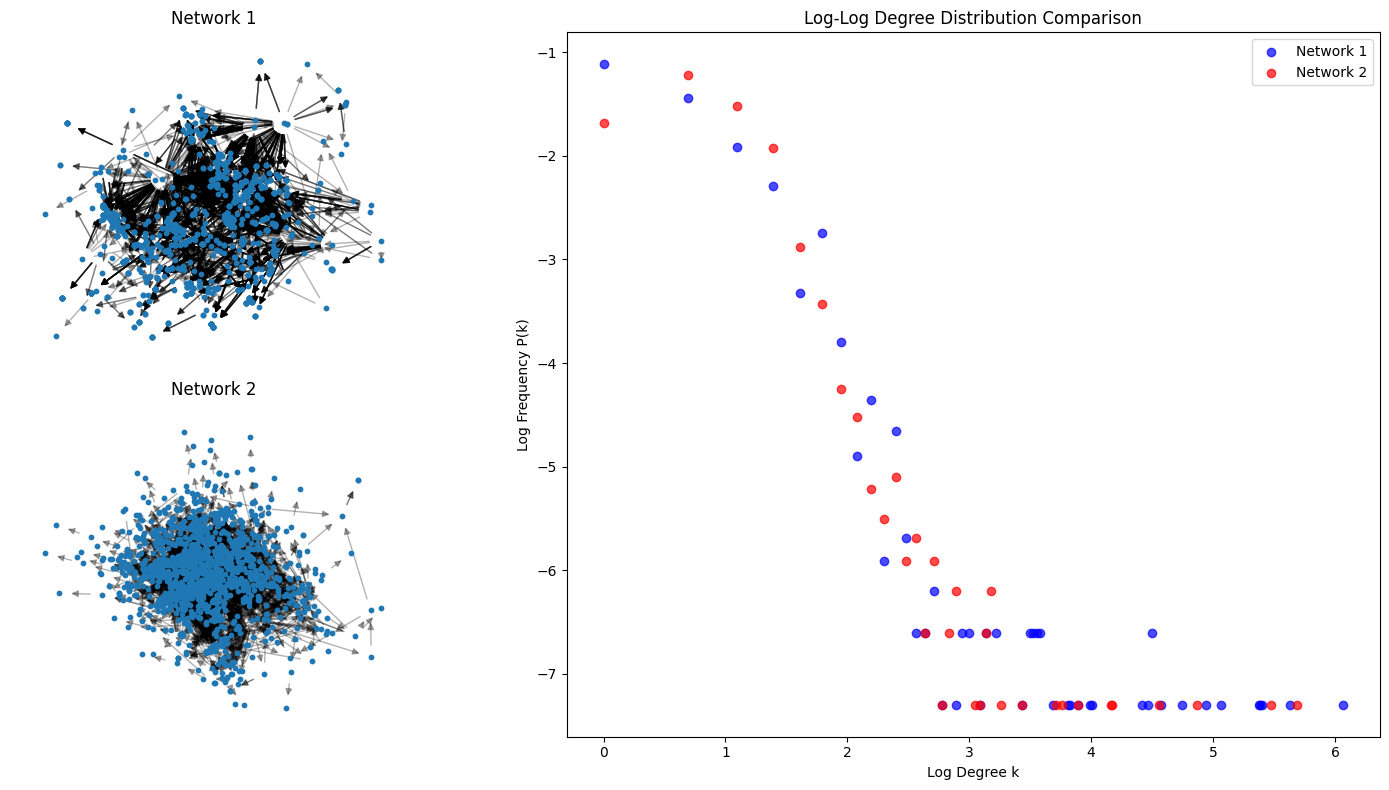

In [36]:
gg.plot_degree_network(ecoli_largest,G_lfr_directed[0])

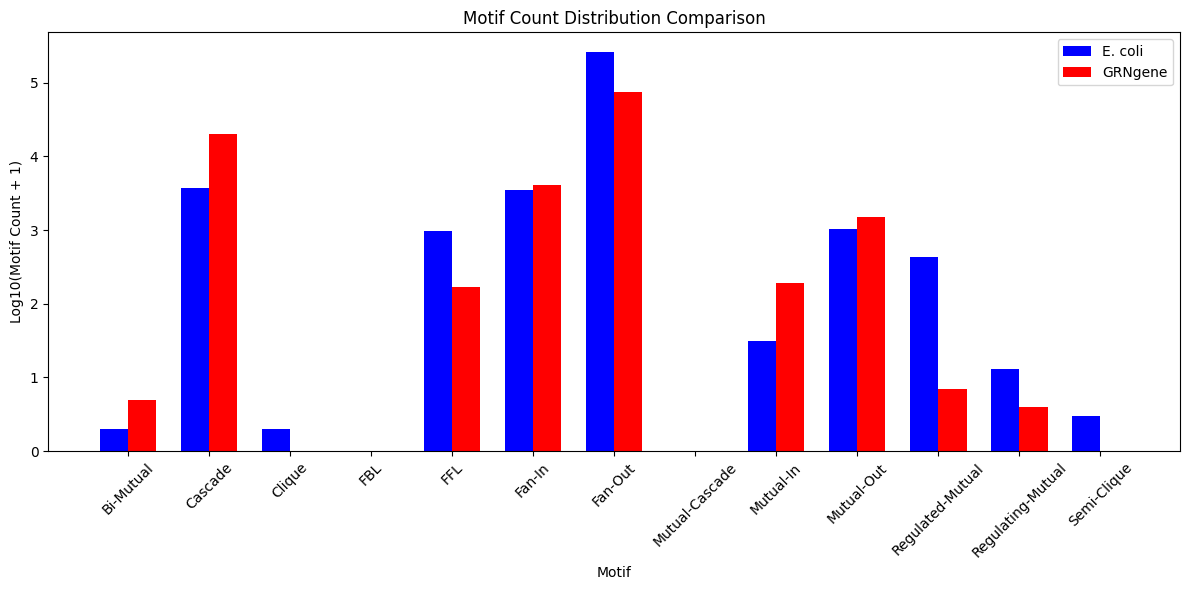

In [38]:
gg.compare_motif_dist(ecoli_largest, G_lfr_directed[0], "E. coli", "GRNgene")#, save_filename='motif_distribution.eps')

In [39]:
pearson_corr, pearson_p, spearman_corr, spearman_p = gg.correlation_metrics(ecoli_largest,  G_lfr_directed[0])

print(f"Pearson correlation: {pearson_corr:.3f} (p={pearson_p:.5f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p={spearman_p:.5f})")

Pearson correlation: 0.937 (p=0.00000)
Spearman correlation: 0.968 (p=0.00000)


# BA

In [ ]:
#x0 = [2.5, 1.5, 0.3, 3, 3.0]

LFR_params = dict(
n=2000,
tau1=2.5,
tau2=1.5,
mu=0.3,
seed=None,
average_degree=4.5,
# min_community=10,
# max_community=300,
hub_bias = 3.0
) # 2600 noeuds

G_lfr = gg.LFRAlgorithm(max_retries=20,**LFR_params)

G_lfr_directed = gg.adjacenteDiMatriceStaredFromGraph(
    G_lfr,
    autoRG=0.0,   # self-loop probability
    duoRG=0.005    # bidirectional edge probability
)

deg_lfr = np.array([d for _, d in G_lfr_directed[0].degree()])  # or in_degree()

# Compare distributions
score = ks_2samp(deg_ecoli, deg_lfr).statistic
print(score)

In [12]:
G_ba = gg.BarabasiAlbertAlgorithm(ecoli_largest.number_of_nodes(),2)

G_ba_directed = gg.adjacenteDiMatriceStaredFromGraph(
    G_ba,
    autoRG=0.0,   # self-loop probability
    duoRG=0.005    # bidirectional edge probability
)

deg_ba = np.array([d for _, d in G_ba_directed[0].degree()])  # or in_degree()

# Compare distributions
score_ba = ks_2samp(deg_ecoli, deg_ba).statistic
print(score_ba)

0.3503459698324003


In [14]:
synth_grn_properties = gg.network_properties(G_ba_directed[0])
synth_grn_properties

{'avg_clustering': 0.005308161288998375,
 'avg_degree': 4.00677048070413,
 'degrees': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 22, 28, 32, 38, 41, 44, 47, 55, 57]),
 'density': 0.0013573070734092581,
 'degree_proba': array([0.00067705, 0.44008125, 0.21868653, 0.11035884, 0.06228842,
        0.0521327 , 0.02234259, 0.02437373, 0.01557211, 0.01286391,
        0.00473934, 0.00812458, 0.00406229, 0.00270819, 0.00338524,
        0.00203114, 0.00067705, 0.00270819, 0.0013541 , 0.00203114,
        0.00203114, 0.00067705, 0.00067705, 0.0013541 , 0.00067705,
        0.00067705, 0.0013541 , 0.00067705, 0.00067705]),
 'modularity_value': 0.5300963718820861,
 'nb_edges': 2959,
 'nb_nodes': 1477,
 'strongly_connected': False,
 'weakly_connected': True}

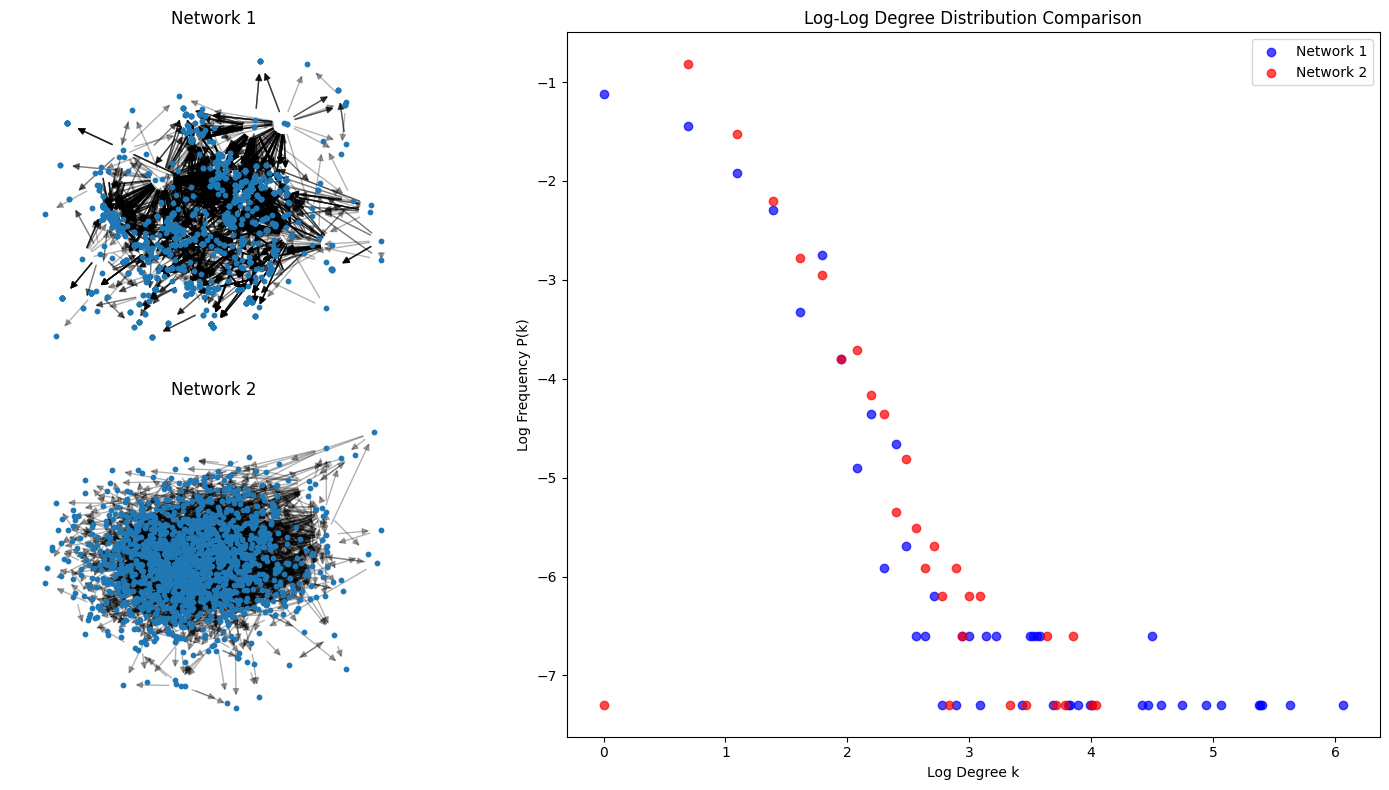

In [13]:
gg.plot_degree_network(ecoli_largest,G_ba_directed[0])

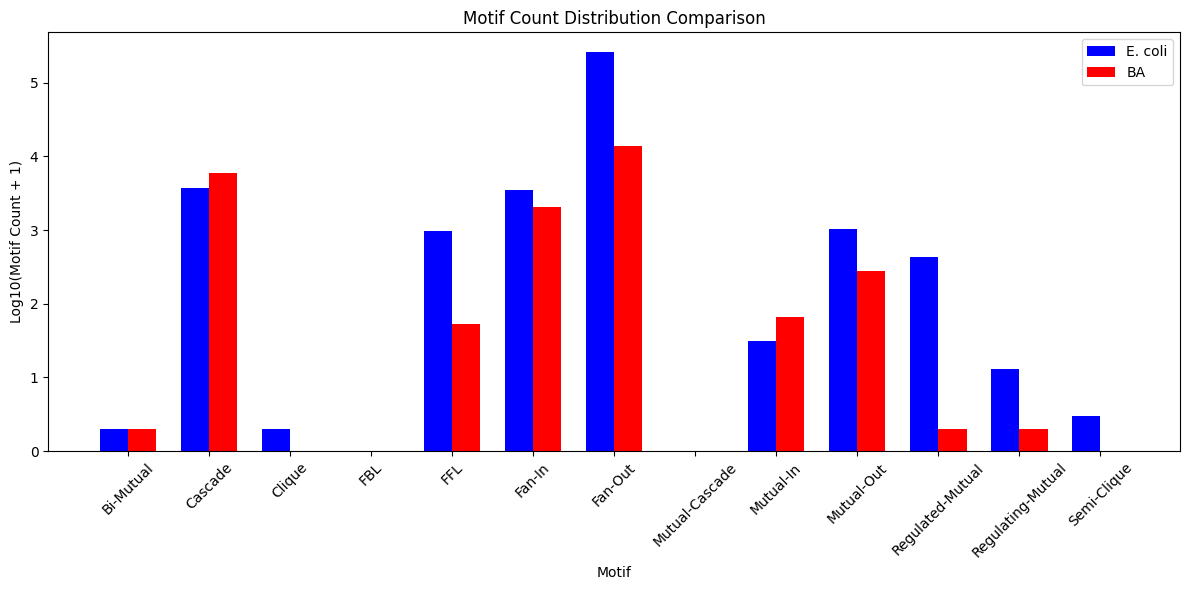

In [15]:
gg.compare_motif_dist(ecoli_largest, G_ba_directed[0], "E. coli", "BA")#, save_filename='motif_distribution.eps')

In [16]:
pearson_corr, pearson_p, spearman_corr, spearman_p = gg.correlation_metrics(ecoli_largest,  G_ba_directed[0])

print(f"Pearson correlation: {pearson_corr:.3f} (p={pearson_p:.5f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p={spearman_p:.5f})")

Pearson correlation: 0.931 (p=0.00000)
Spearman correlation: 0.912 (p=0.00001)
